# Marketing Budget Optimization Analysis

This notebook demonstrates how to use the marketing budget optimizer and analyze its convergence properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from marketing_budget_optimizer.optimize import GeneticAlgorithmOptimizer
from marketing_budget_optimizer.curves import HillCurve

## 1. Set up the optimization problem

First, let's define our marketing channels and their response curves. We'll use Gompertz curves which are good for modeling diminishing returns in marketing spend.

In [2]:
# Create response curves with increasing returns initially, then diminishing returns
# Using Hill curves with carefully chosen parameters to create S-shaped curves that cross
curves = [
    # Channel 1: Quick initial growth, early inflection
    HillCurve(V=12000000, K=500000, n=2.5),  # Lower K for earlier inflection, moderate n for clear S-shape
    # Channel 2: Very slow initial growth, very late inflection
    HillCurve(V=15000000, K=1500000, n=3.0),  # Higher K for later inflection, higher n for steeper S-shape
    # Channel 3: Moderate growth, mid-range inflection
    HillCurve(V=13000000, K=800000, n=2.8),
    # Channel 4: Very quick initial growth, very early inflection
    HillCurve(V=11000000, K=300000, n=2.2),  # Very low K for very early inflection, lower n for gentler S-shape
    # Channel 5: Extremely slow initial growth, extremely late inflection
    HillCurve(V=16000000, K=2000000, n=3.2),  # Very high K for very late inflection, higher n for steeper S-shape
    # Channel 6: Quick growth, mid-early inflection
    HillCurve(V=12500000, K=600000, n=2.6),
    # Channel 7: Slow growth, mid-late inflection
    HillCurve(V=14000000, K=1200000, n=2.9),
    # Channel 8: Moderate growth, late inflection
    HillCurve(V=13500000, K=1000000, n=2.7)
]

# Set budget constraints with variation by channel
total_budget = 10000000  # $10M total budget

# Minimum budgets vary by channel (in thousands)
# Only channels 1, 4, and 7 have minimum constraints
min_budgets = [
    300000,  # Channel 1: Lower minimum for quick-return channel
    0,       # Channel 2: No minimum
    0,       # Channel 3: No minimum
    200000,  # Channel 4: Very low minimum for very quick-return channel
    0,       # Channel 5: No minimum
    0,       # Channel 6: No minimum
    600000,  # Channel 7: Higher minimum for quick-return channel
    0        # Channel 8: No minimum
]

# Maximum budgets vary by channel (in thousands)
# Only channels 1, 4, and 7 have maximum constraints
max_budgets = [
    1500000, # Channel 1: Lower maximum for quick-return channel
    float('inf'),  # Channel 2: No maximum
    float('inf'),  # Channel 3: No maximum
    1200000, # Channel 4: Very low maximum for very quick-return channel
    float('inf'),  # Channel 5: No maximum
    float('inf'),  # Channel 6: No maximum
    2200000, # Channel 7: Higher maximum for quick-return channel
    float('inf')   # Channel 8: No maximum
]

## 2. Configure and run the optimizer

We'll use a parameter search to find the best parameters

In [3]:
def perform_parameter_search(curves, total_budget, min_budgets, max_budgets, n_runs_per_config=3):
    # Define parameter ranges to search
    param_ranges = {
        'population_size': [100, 200, 300],
        'generations': [50, 100, 150],
        'mutation_rate': [0.05, 0.1, 0.15],
        'elite_size': [5, 10, 15],
        'tournament_size': [3, 4, 5]
    }
    
    # Generate all parameter combinations
    from itertools import product
    param_combinations = [
        dict(zip(param_ranges.keys(), values))
        for values in product(*param_ranges.values())
    ]
    
    # Track results
    results = []
    best_result = None
    best_fitness = float('-inf')
    
    for params in param_combinations:
        # Create optimizer with current parameters
        optimizer = GeneticAlgorithmOptimizer(**params)
        
        # Run multiple times for this configuration
        run_results = []
        for _ in range(n_runs_per_config):
            result = optimizer.optimize(
                curves=curves,
                budget=total_budget,
                min_budgets=min_budgets,
                max_budgets=max_budgets,
                track_metrics=True
            )
            run_results.append(result)
        
        # Calculate average metrics
        avg_fitness = np.mean([r['convergence_metrics']['best_fitness'] for r in run_results])
        std_fitness = np.std([r['convergence_metrics']['best_fitness'] for r in run_results])
        
        # Store results
        config_result = {
            'parameters': params,
            'avg_fitness': avg_fitness,
            'std_fitness': std_fitness,
            'best_run': max(run_results, key=lambda x: x['convergence_metrics']['best_fitness'])
        }
        results.append(config_result)
        
        # Update best result
        if avg_fitness > best_fitness:
            best_fitness = avg_fitness
            best_result = config_result
    
    return results, best_result

In [4]:
# Run parameter search
search_results, best_config = perform_parameter_search(
    curves, total_budget, min_budgets, max_budgets, n_runs_per_config=3
)

# Print top 5 configurations
print("\nTop 5 Parameter Configurations:")
for i, result in enumerate(sorted(search_results, key=lambda x: x['avg_fitness'], reverse=True)[:5]):
    print(f"\n{i+1}. Average Fitness: {result['avg_fitness']:.2f} ± {result['std_fitness']:.2f}")
    print(f"   Parameters: {result['parameters']}")

/Users/stephenbigelow/repositories/marketing_budget_optimizer/venv/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Top 5 Parameter Configurations:

1. Average Fitness: 100415644.42 ± 244996.20
   Parameters: {'population_size': 300, 'generations': 150, 'mutation_rate': 0.15, 'elite_size': 10, 'tournament_size': 3}

2. Average Fitness: 99957774.51 ± 125719.31
   Parameters: {'population_size': 300, 'generations': 50, 'mutation_rate': 0.15, 'elite_size': 10, 'tournament_size': 3}

3. Average Fitness: 99772939.88 ± 1270768.11
   Parameters: {'population_size': 300, 'generations': 100, 'mutation_rate': 0.1, 'elite_size': 5, 'tournament_size': 3}

4. Average Fitness: 99698175.63 ± 614460.82
   Parameters: {'population_size': 300, 'generations': 150, 'mutation_rate': 0.05, 'elite_size': 15, 'tournament_size': 3}

5. Average Fitness: 99660717.14 ± 706075.27
   Parameters: {'population_size': 300, 'generations': 50, 'mutation_rate': 0.05, 'elite_size': 15, 'tournament_size': 3}


In [5]:
# Use the best configuration for final optimization
best_optimizer = GeneticAlgorithmOptimizer(**best_config['parameters'])
final_result = best_optimizer.optimize(
    curves=curves,
    budget=total_budget,
    min_budgets=min_budgets,
    max_budgets=max_budgets,
    track_metrics=True
)

## 3. Analyze the results

In [6]:
# Get the optimal allocation and responses
optimal_allocation = final_result['allocation']
channel_responses = final_result['response']
total_response = final_result['total_response']

# Get convergence metrics
convergence_metrics = final_result['convergence_metrics']
best_fitness_history = final_result['best_fitness']
std_fitness_history = final_result['std_fitness']
best_allocation_history = final_result['best_allocation']

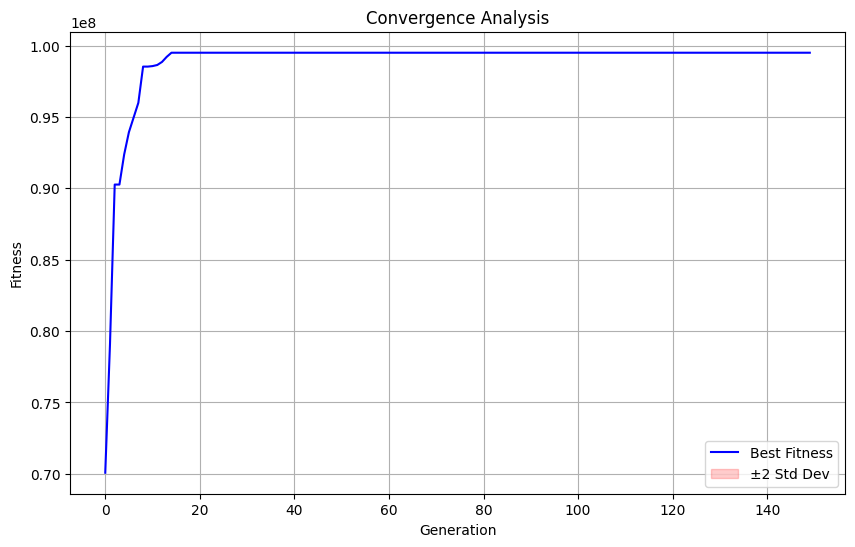

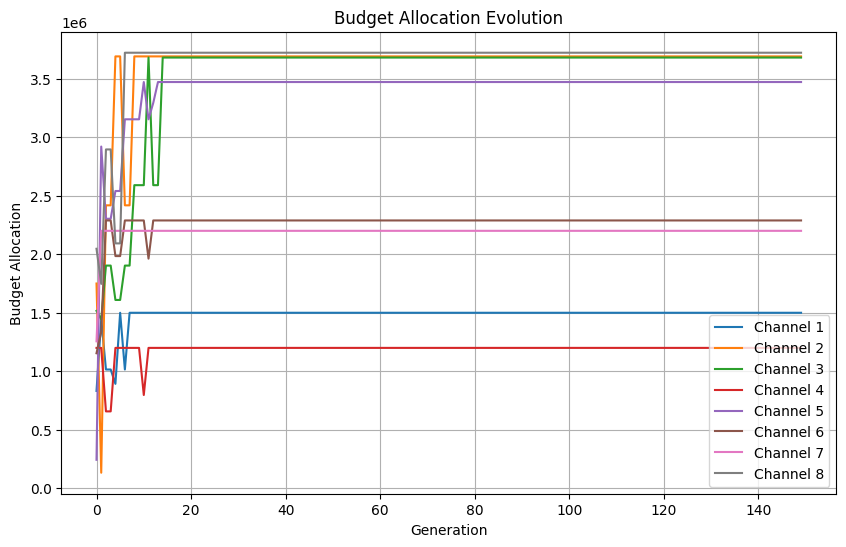

In [14]:
# Plot convergence metrics
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history, label='Best Fitness', color='blue')
plt.fill_between(range(len(best_fitness_history)), 
                 best_fitness_history - std_fitness_history * 2,
                 best_fitness_history + std_fitness_history * 2,
                 alpha=0.2, color='red', label='±2 Std Dev')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True)
plt.show()

# Plot budget allocation evolution
plt.figure(figsize=(10, 6))
for i in range(len(curves)):
    plt.plot(best_allocation_history[:, i], label=f'Channel {i+1}')
plt.xlabel('Generation')
plt.ylabel('Budget Allocation')
plt.title('Budget Allocation Evolution')
plt.legend()
plt.grid(True)
plt.show()